# Introduction

**Fake Face Generator using GAN network**

In [ ]:
import os
import json
from zipfile import ZipFile
import cv2

# Data Loading

## connecting to kaggle

In [ ]:
kaggle_credentails = json.load(open("kaggle.json"))

os.environ['KAGGLE_USERNAME']= kaggle_credentails["username"]
os.environ['KAGGLE_KEY']= kaggle_credentails["key"]

## download and unzip

In [ ]:
!kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:05<00:00, 24.6MB/s]
100% 1.33G/1.33G [01:05<00:00, 21.9MB/s]


In [ ]:
!unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

## Loading and Preprocessing

In [ ]:
DATA_DIR = 'img_align_celeba/img_align_celeba'
IMG_SHAPE = (64, 64, 3)
NUM_IMAGES = 10_000
BATCH_SIZE = 128

In [ ]:
import numpy as np

In [ ]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image_array = np.array(image, dtype=np.float32)
    image_array = image / 255.0

    return image_array

In [ ]:
def load_images(data_dir, num_images, img_shape):
    image_files = os.listdir(data_dir)
    np.random.shuffle(image_files)
    selected_files = image_files[:num_images]
    images = []
    for file_name in selected_files:
        file_path = os.path.join(data_dir, file_name)
        image = load_and_preprocess_image(file_path, img_shape[:2])
        images.append(image)
    return np.array(images)

train_images = load_images(DATA_DIR, NUM_IMAGES, IMG_SHAPE)
train_images = train_images.reshape((-1, 64, 64, 3))
train_labels = np.ones((NUM_IMAGES, 1))

In [ ]:
train_images.shape

(10000, 64, 64, 3)

#Designing Model Network

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

## Building the Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(layers.Conv2D(182, (5, 5), strides=(2, 2), padding='same',
                            input_shape=IMG_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002)
    model.compile(loss='binary_crossentropy', optimizer=opt,
                 metrics=['accuracy'])

    return model
dis = build_discriminator()
dis.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 182)       13832     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 182)       0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 182)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       582528    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0

## Building the Generator

In [ ]:
def build_generator():
    model = Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))
    return model
gen = build_generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)      

## defining GAN network

In [ ]:
def define_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr=0.0002)
  model.compile(loss='binary_crossentropy', optimizer=opt,
                metrics=['accuracy'])

  return model

## Data loaders

In [ ]:
from numpy.random import randn
from numpy.random import randint

def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))

  return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  X_input = randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)

  return X_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = np.zeros((n_samples, 1 ))
  return X, y

# Trainning

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim,
          n_epochs=6, n_batch=BATCH_SIZE):
  bat_per_epo = int(10000 / n_batch)

  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake  = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)

In [ ]:
latent_dim = 100
discriminator = build_discriminator()
generator = build_generator()
gan_model = define_gan(generator, discriminator)

train(generator, discriminator, gan_model, train_images, latent_dim, n_epochs=250)

2/2 [==============================] - 0s 179ms/step
1 1 78 0.7082327008247375 0.7019047737121582 [0.8512066006660461, 0.0]
2/2 [==============================] - 0s 180ms/step
1 2 78 0.00984297227114439 0.6755816340446472 [0.9911094903945923, 0.0]
2/2 [==============================] - 0s 178ms/step
1 3 78 0.00034932588459923863 0.5149738788604736 [2.7181270122528076, 0.0]
2/2 [==============================] - 0s 182ms/step
1 4 78 0.0024855623487383127 0.16355788707733154 [13.444077491760254, 0.0]
2/2 [==============================] - 1s 310ms/step
1 5 78 8.844024658203125 0.15791624784469604 [6.866335411359614e-08, 1.0]
2/2 [==============================] - 0s 177ms/step
1 6 78 3.399503789580649e-09 2.354470729827881 [6.980409635630122e-16, 1.0]
2/2 [==============================] - 1s 297ms/step
1 7 78 4.0316745832707004e-18 5.831733703613281 [1.684979573973647e-19, 1.0]
2/2 [==============================] - 0s 185ms/step
1 8 78 4.519575724547837e-22 7.311186790466309 [4.744711

# Testing

In [ ]:
import matplotlib.pyplot as plt

def generate_and_save_images():
    latent_points = generate_latent_points(100, 20)
    X = generator.predict(latent_points)

    X = (X + 1) / 2.0

    for i in range(10):
        plt.subplot(4, 5, i + 1)
        plt.imshow((X[i]))
        plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 21ms/step


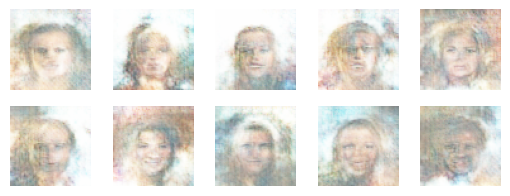

In [ ]:
generate_and_save_images()

In [ ]:
generator.save('fake_face_generator_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
